In [ ]:
#!pip install dowhy

In [2]:
import pdb
import numpy as np
import pandas as pd

import pickle
from matplotlib import pyplot as plt

import dowhy
import dowhy.datasets
from dowhy import CausalModel

import networkx as nx

In [17]:
data_path = 'data_dir/'


## Load Bayesian Network 

In [35]:
causal_graph='bayesian-network-sample'

In [36]:
df = pd.read_csv(data_path+causal_graph+'.txt', sep='v_',header=None, names=['Num','cause', 'effect'] ) 

/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [37]:
df['effect']=df['effect'].astype(str)
df['relation']=df['cause'].apply(lambda x: x[-4:-1])
df['cause']=df['cause'].apply(lambda x: x[:-5])
df.drop('Num', axis=1, inplace=True)
df['cause']=df['cause'].apply(lambda x: 'v_'+str(x))
df['effect']=df['effect'].apply(lambda x: 'v_'+str(x))
#create a graph
G=nx.from_pandas_edgelist(df, source='cause',target='effect')
nx.write_gml(G,data_path+causal_graph+'.gml')

In [38]:
df

,cause,effect,relation
0,v_dx1,v_AD,-->
1,v_dx2,v_AD,-->
2,v_dx3,v_AD,-->
3,v_dx1,v_dx3,-->
4,v_dx5,v_dx3,-->
5,v_dx4,v_dx3,-->


## Define causal model

In [39]:
data_file='occurrence_sample.txt'

In [40]:
data = pd.read_csv(data_path+data_file)

In [41]:
data

,v_dx1,v_dx2,v_dx3,v_dx4,v_dx5,v_AD
0,0.1,0.3,5.2,1.4,6.7,1
1,0.1,0.2,3.2,3.1,7.1,0
2,0.9,0.1,3.1,4.3,1.8,1
3,0.1,0.9,3.1,0.4,5.3,0


In [42]:
treatment='v_dx1'
outcome='v_AD'
data[treatment]=data[treatment].astype(bool)
data[outcome]=data[outcome].astype(bool)

In [43]:
model=CausalModel(data=data,
                 treatment=treatment,
                 outcome=outcome,
                 graph=data_path+causal_graph+'.gml')

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v_dx1'] on outcome ['v_AD']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


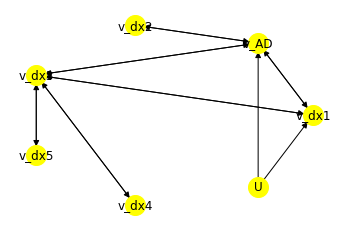

In [44]:
model.view_model()

In [45]:
identified_estimand=model.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['v_dx4', 'U', 'v_dx3', 'v_dx5', 'v_dx2']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [46]:
print(identified_estimand)

Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                               
────────(Expectation(v_AD|v_dx4,v_dx3,v_dx5,v_dx2))
d[v_dx1]                                           
Estimand assumption 1, Unconfoundedness: If U→{v_dx1} and U→v_AD then P(v_AD|v_dx1,v_dx4,v_dx3,v_dx5,v_dx2,U) = P(v_AD|v_dx1,v_dx4,v_dx3,v_dx5,v_dx2)
### Estimand : 2
Estimand name: iv
No such variable found!



## Estimate causal effect

In [ ]:
estimate=model.estimate_effect(identified_estimand,
                              method_name='backdoor.propensity_score_matching', target_units='ate')

# estimate=model.estimate_effect(identified_estimand,
#                               method_name='backdoor.propensity_score_weighting',
#                                method_params={"weighting_scheme":"ips_normalized_weight"},
#                               target_units='att')

# estimate=model.estimate_effect(identified_estimand,
#                               method_name='backdoor.propensity_score_stratification', 
#                                target_units='atc')

In [ ]:
print(estimate)

In [ ]:
estimate.get_confidence_intervals()

## Refute

In [ ]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",)
print(res_placebo)